# Analiza społeczności

In [29]:
from helpers import read_jsonline, extract_mentions
import pandas as pd
from tqdm.auto import tqdm

tqdm.pandas()
    
df_tweets = read_jsonline("../datasets/tweets_all_tagged.jl")
df_tweets["mentions"] = df_tweets["tweet"].progress_apply(extract_mentions)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


100%|██████████| 312502/312502 [00:02<00:00, 131358.70it/s]


In [2]:
print(f"Liczba zebranych tweetów: {len(df_tweets)}")

Liczba zebranych tweetów: 312502


In [3]:
df_users = read_jsonline("../datasets/users_all.jl")

In [4]:
print(f"Liczba użytkowników, którzy napisali tweety: {len(df_users)}")

Liczba użytkowników, którzy napisali tweety: 42146


In [5]:
df_affiliation = pd.read_csv("../datasets/affiliations.csv")

In [6]:
df_affiliation["username"].isin(df_users["username"]).value_counts()

True     253
False     38
Name: username, dtype: int64

dla 38 polityków udało się zebrać jedynie wzmiankę (oznaczenie)

In [7]:
df_users = df_users.join(df_affiliation.set_index("username"), on="username")
df_users["affiliation"] = df_users["affiliation"].fillna("none")

In [8]:
df_politicians = df_users[df_users["affiliation"] != "none"]

In [9]:
df_politician_tweets = df_tweets[df_tweets["user_id"].isin(df_politicians["id"])].reset_index(drop=True)
print(f"Liczba tweetów autorstwa wybranych polityków: {len(df_politician_tweets)}")

Liczba tweetów autorstwa wybranych polityków: 5421


In [10]:
df_politician_tweets["user_id"].nunique()

151

## Wizualizacja interakcji między politykami

In [12]:
from consts import query_name_mapping, get_color_by_query_name
import networkx as nx
import plotly.graph_objects as go
from typing import Optional


def nx_to_plotly(graph: nx.Graph, save_name: Optional[str] = None):
    positions = nx.drawing.layout.kamada_kawai_layout(graph, scale=20)
    max_degree = max([x[1] for x in graph.degree()])

    traces_data = {}
    for party in df_affiliation["affiliation"].unique():
        traces_data[party] = {"node_x": [], "node_y": [], "node_texts": []}

    for node in graph:
        x, y = positions[node]
        party = df_affiliation[df_affiliation["username"] == node].iloc[0][
            "affiliation"
        ]
        traces_data[party]["node_x"].append(x)
        traces_data[party]["node_y"].append(y)
        traces_data[party]["node_texts"].append(node)

    node_traces = []
    for party, trace_data in traces_data.items():
        first = True
        for x, y, text in zip(trace_data["node_x"], trace_data["node_y"], trace_data["node_texts"]):
            degree = graph.degree(text)
            node_trace = go.Scatter(
                x=[x],
                y=[y],
                mode="markers",
                hoverinfo="text",
                text=text,
                name=query_name_mapping[party],
                marker=dict(
                    size=10 * ((degree / max_degree) * 2 + 1),
                    line_width=2,
                    color=get_color_by_query_name(party)
                ),
                showlegend=first,
            )
            first = False
            node_traces.append(node_trace)

    edge_x = []
    edge_y = []

    for edge in graph.edges():
        x0, y0 = positions[edge[0]]
        x1, y1 = positions[edge[1]]
        edge_x.append(x0)
        edge_x.append(x1)
        edge_y.append(y0)
        edge_y.append(y1)

    edge_trace = go.Scatter(
        x=edge_x,
        y=edge_y,
        line=dict(width=0.5, color="#888"),
        hoverinfo="none",
        mode="lines",
        showlegend=False,
    )

    fig = go.Figure(
        data=[edge_trace, *node_traces],
        layout=go.Layout(
            title={
                "text": "Interakcje między politykami",
                "y": 0.9,
                "x": 0.5,
                "xanchor": "center",
                "yanchor": "top",
            },
            titlefont_size=16,
            showlegend=True,
            legend_title_text="Partia",
            xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
            yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
            width=1000,
            height=600,
        ),
    )

    fig.show()
    if save_name is not None:
        fig.write_image(save_name, width=2000, height=1200)


In [13]:
graph_politicians = nx.Graph()

for _, row in df_politician_tweets.iterrows():
    username = df_politicians[df_politicians["id"] == row["user_id"]].iloc[0]
    username = username["username"]
    for user in row["mentions"]:
        if user == username:
            continue
        if user in df_politicians["username"]:
            graph_politicians.add_edge(username, user)
    if row["id"] != row["conversation_id"]: # comment
        recipient_id = df_politician_tweets.loc[df_politician_tweets["id"] == row["conversation_id"]]["user_id"]
        if len(recipient_id):
            recipient_id = recipient_id.iloc[0]
            recipient = df_politicians[df_politicians["id"] == recipient_id].iloc[0]
            if recipient["username"] == username:
                continue
            graph_politicians.add_edge(username, recipient["username"])

In [14]:
print(f"Liczba wierzchołków: {graph_politicians.number_of_nodes()}")

Liczba wierzchołków: 83


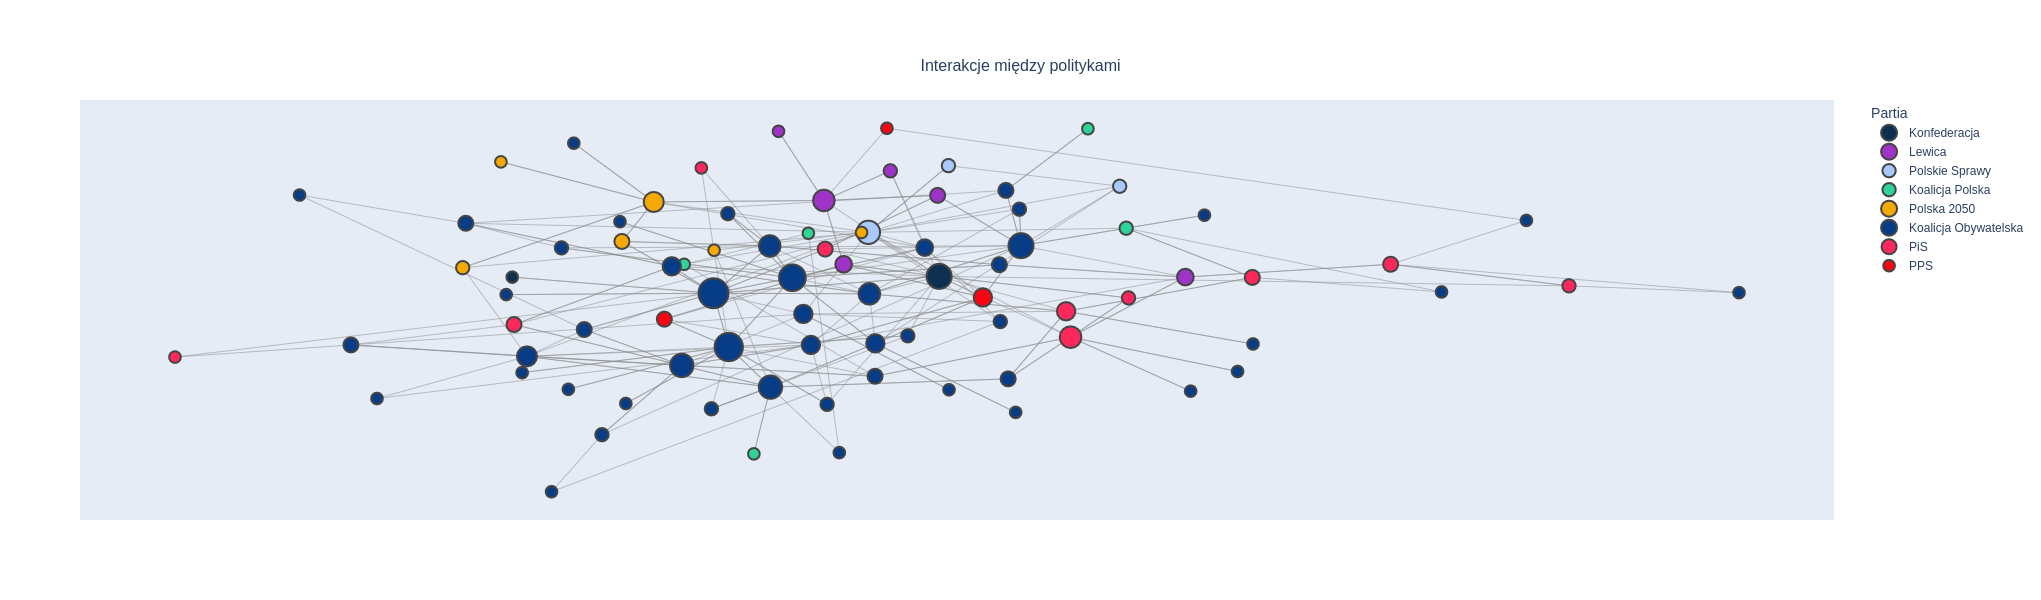

In [15]:
nx_to_plotly(graph_politicians, "parties.png")

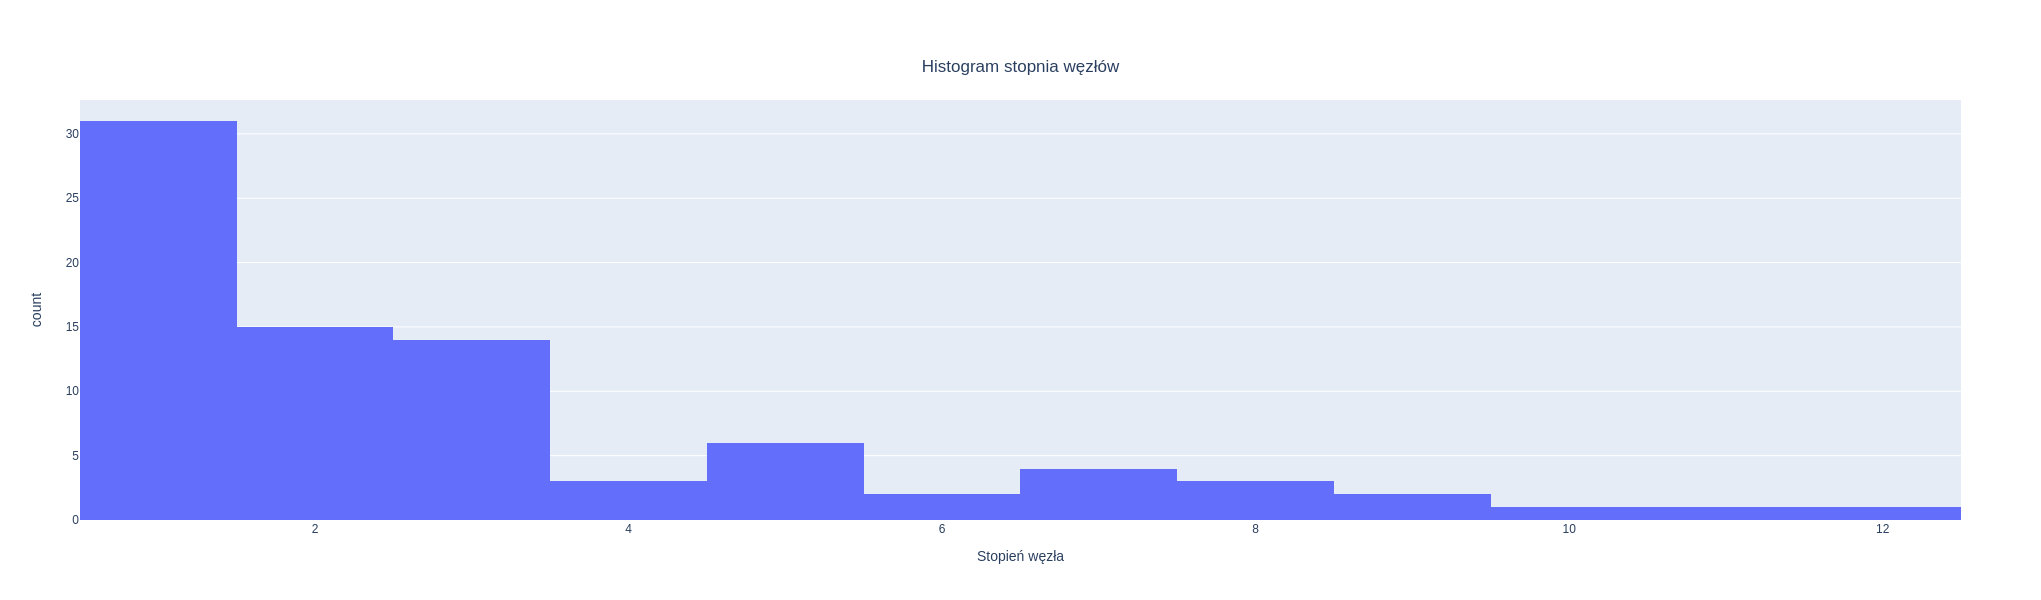

In [16]:
import plotly.express as px

fig = px.histogram(
    [x[1] for x in graph_politicians.degree()], title="Histogram stopnia węzłów", width=800, height=600
)
fig.update_layout(
    xaxis_title="Stopień węzła",
    title={
        "text": "Histogram stopnia węzłów",
        "y": 0.9,
        "x": 0.5,
        "xanchor": "center",
        "yanchor": "top",
    },
    showlegend=False
)
fig.show()

## Wizualizacja interakcji między największymi haterami

In [53]:
posts_per_user = df_tweets.groupby(["user_id"]).size()
posts_per_user = posts_per_user.to_frame().reset_index().rename(columns={0: "all"})

df_tweets_hate = df_tweets[df_tweets["offensive"] == 1]
hate_per_user = df_tweets_hate.groupby(["user_id"]).size()
hate_per_user = hate_per_user.to_frame().reset_index().rename(columns={0: "hate"})

users_stats = posts_per_user.merge(hate_per_user, how="left", on="user_id")
users_stats.fillna(0, inplace=True)
users_stats["hate_coefficient"] = users_stats["hate"] / users_stats["all"]

top_100 = users_stats.sort_values(by="hate", ascending=False).iloc[:300].reset_index(drop=True)

In [54]:
top_100 = top_100.join(df_users.set_index("id"), on="user_id")
top_100

,user_id,all,hate,hate_coefficient,name,username,bio,location,join_date,join_time,tweets,following,followers,likes,affiliation
0,838191930399997953,266,177.0,0.665414,P MirosławK 🇵🇱🇪🇺 #SilniRazem,MK6112,"Patriota ceniący wolnośc i demokrację, liberał...",Zielona Góra PO PL UE,2017-03-05,00:58:23 UTC,192299.0,1528.0,1581.0,175991.0,none
1,1383376953219063811,300,165.0,0.550000,AnNi,nowyanni211121,"Zwykły użytkownik TT, konto nr 2.",,2021-04-17,11:09:15 UTC,46809.0,1011.0,532.0,32416.0,none
2,1026867931,197,159.0,0.807107,Eliza Alicja,SeliwiakE,Chrońmy wiarę KK ✝️ Popieram PIS 🇵🇱 KONSTYTUC...,"Wrocław, Polska",2012-12-21,17:59:12 UTC,64890.0,4999.0,4237.0,296816.0,none
3,1427677539787550727,238,132.0,0.554622,Space Intruder 🇵🇱 #MuremZaPolskimMundurem,SpaceIntruder2,Studio Produkcji Muzycznej. Space Music World ...,,2021-08-17,17:06:35 UTC,12699.0,36.0,94.0,12414.0,none
4,620191832,296,121.0,0.408784,M.J. Stolzman 🇵🇱🇺🇸,MattStolzman,"🐸\n____\nFilm photography enthusiast, analog s...",Ziemia Obiecana,2012-06-27,17:39:11 UTC,9082.0,273.0,333.0,34967.0,none
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,1275346001851801600,69,35.0,0.507246,Dojcze_kabana,Clin33268197,#czyścić aka łyskaczyk z guinnessikiem,,2020-06-23,08:32:50 UTC,12477.0,129.0,47.0,3966.0,none
296,1430890578762342408,69,35.0,0.507246,Oxygen bis,OxygenBis,Warszawska Gazeta...to jest to,,2021-08-26,13:52:15 UTC,3434.0,21.0,20.0,2560.0,none
297,895365999855362048,73,35.0,0.479452,Femek Maniewicz,Przemek95647013,precz z komuną,"Mazowieckie, Polska",2017-08-09,19:27:44 UTC,1021.0,177.0,14.0,1247.0,none
298,144544892,52,35.0,0.673077,Andrew Zeig,commodore997,Show me what u can? LOL.,NYC/Dyker Hts.,2010-05-16,16:16:37 UTC,26545.0,281.0,276.0,71367.0,none


In [55]:
df_tweets_haters = df_tweets[df_tweets["user_id"].isin(top_100["user_id"])]

In [56]:
graph_haters = nx.Graph()

for _, row in tqdm(df_tweets_haters.iterrows(), total=len(df_tweets_haters)):
    username = top_100[top_100["user_id"] == row["user_id"]].iloc[0]
    username = username["username"]
    for user in row["mentions"]:
        if user == username:
            continue
        if user in top_100["username"]:
            graph_haters.add_edge(username, user)
    if row["id"] != row["conversation_id"]: # comment
        recipient_id = df_tweets_haters.loc[df_tweets_haters["id"] == row["conversation_id"]]["user_id"]
        if len(recipient_id):
            recipient_id = recipient_id.iloc[0]
            recipient = top_100[top_100["user_id"] == recipient_id].iloc[0]
            if recipient["username"] == username:
                continue
            graph_haters.add_edge(username, recipient["username"])

100%|██████████| 31323/31323 [00:18<00:00, 1690.89it/s]


In [57]:
print(f"Liczba wierzchołków: {graph_haters.number_of_nodes()}")

Liczba wierzchołków: 156


In [58]:
fig = px.histogram(
    [x[1] for x in graph_haters.degree()], title="Histogram stopnia węzłów", width=800, height=600
)
fig.update_layout(
    xaxis_title="Stopień węzła",
    title={
        "text": "Histogram stopnia węzłów",
        "y": 0.9,
        "x": 0.5,
        "xanchor": "center",
        "yanchor": "top",
    },
    showlegend=False
)
fig.show()

In [59]:
def nx_to_plotly_haters(graph: nx.Graph, save_name: Optional[str] = None):
    positions = nx.drawing.layout.kamada_kawai_layout(graph, scale=20)

    positions = nx.drawing.layout.kamada_kawai_layout(graph)
    node_x = []
    node_y = []

    for node in graph:
        x, y = positions[node]
        node_x.append(x)
        node_y.append(y)

    node_trace = go.Scatter(
        x=node_x,
        y=node_y,
        mode="markers",
        hoverinfo="text",
        text=list(graph.nodes()),
        marker=dict(
            size=10,
            line_width=2,
        ),
    )

    edge_x = []
    edge_y = []

    for edge in graph.edges():
        x0, y0 = positions[edge[0]]
        x1, y1 = positions[edge[1]]
        edge_x.append(x0)
        edge_x.append(x1)
        edge_y.append(y0)
        edge_y.append(y1)

    edge_trace = go.Scatter(
        x=edge_x,
        y=edge_y,
        line=dict(width=0.5, color="#888"),
        hoverinfo="none",
        mode="lines",
        showlegend=False,
    )

    fig = go.Figure(
        data=[edge_trace, node_trace],
        layout=go.Layout(
            title={
                "text": "Interakcje między haterami",
                "y": 0.9,
                "x": 0.5,
                "xanchor": "center",
                "yanchor": "top",
            },
            titlefont_size=16,
            showlegend=False,
            hovermode="closest",
            xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
            yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
            width=1000,
            height=600,
        ),
    )

    fig.show()

In [60]:
nx_to_plotly_haters(graph_haters)

In [65]:
user_id = df_users[df_users["username"] == "AM_Zukowska"]["id"].iloc[0]
offensive_tweets = df_tweets[(df_tweets["user_id"] == user_id) & (df_tweets["offensive"] == 1)]
print(offensive_tweets["tweet"].tolist())

['Represje katolików? Dla @pisorgpl to nie problem, pomimo głoszonych frazesów o ochronie wiary.', '@mac_kozlowski @PSocjalistyczna W marcu podobno macie kongres. I albo nastąpi wrogie przejęcie przez polityków, którzy z partią nie mieli dotąd nic wspólnego, albo socjaliści obronią PPS przed byciem trampoliną do miejsc na listach KO.', '@80gam_pl U nas pokutuje też zły stosunek do partii jako takich. Ludzie się do żadnej nie będą masowo zapisywać dopóki żyją ludzie, którzy używają zdania „byłeś w partii!” jako wyrzutu (mając na myśli PZPR).', '@szprotest @e_bartkowska Kcem', '@MateuszGotz @chmiels Daj spokój, woluntaryjnych nieuków już nie dokształcisz.', '@LaGosiaK W taki, że np. blokuje nielegalne eksmisje tych biednych.', '@Adam87139609 @julia3302 Nie ma. Wszak przyznał, że socjaliści są też choćby w @partiarazem. Tylko, żeby być socjalistą, nie wystarczy się zapisać do partii ze słowem „socjalistyczna” w nazwie.', '@RafalFrelek @airborell To się liczy dla politykierów, a nie polity